In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed, Conv1D, Flatten
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.switch_backend('TkAgg')
%matplotlib inline

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

np.random.seed(7)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Using TensorFlow backend.


In [3]:
# usuful functions


def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]


def create_datasets(dataset, look_back=1, look_ahead=1, jump=1):
    data_x, data_y = [], []
    for i in range(0, len(dataset)-look_back-look_ahead+1, jump):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)


def reverse_scale(data, mean, std):
    return data*std + mean


def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score


def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100


def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print(i+1, "  ->  ", score)
        
    return score


def plot_errors(pred_test, test_y, errors):
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.plot(test_y[:,23,:], label="Observed")
    plt.plot(pred_test[:,23,:], color="red", label="Predicted, MAPE: "+ str(round(errors[23], 5))+"%")
    plt.title("24 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(312)
    plt.plot(pred_test[:,47,:], color="red", label="Predicted, MAPE: "+ str(round(errors[47], 5))+"%")
    plt.plot(test_y[:,47,:], label="Observed")
    plt.title("48 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(313)
    plt.plot(pred_test[:,71,:], color="red", label="Predicted, MAPE: "+ str(round(errors[71], 5))+"%")
    plt.plot(test_y[:,71,:], label="Observed")
    plt.title("72 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.tight_layout()
    plt.show()
    

def build_seq2seq_model(look_ahead=1):
    m = Sequential()
    
    # encoder
    m.add(GRU(16, input_shape=(None, 1)))
    # m.add(GRU(16, input_dim = 1))
    
    # repeat for the number of steps out
    m.add(RepeatVector(look_ahead))
    
    # decoder
    m.add(GRU(8, return_sequences=True))
    m.add(GRU(8, return_sequences=True))
    
    # split the output into timesteps
    m.add(TimeDistributed(Dense(1)))
    
    m.compile(loss='mse', optimizer='rmsprop')
    
    m.summary()
    return m


In [40]:
for i in range(1):
    # print(f"cells={i}")
    scores = []
    history = []
    model_list = []
    river_i_list = [5]
    look_back = 24*7
    look_ahead = 72
    N = 24 * 30 * 24 + look_back * look_ahead
    split = 0.8
    batch_size=200
    epochs=100


    river = all_levels[:N, 5]  # zgz
    # river = np.diff(river, axis=0)

    # normalize
    river_mean, river_std = river.mean(), river.std()
    river = preprocessing.scale(river)[:, None]

    # split data into train and test subsets
    train, test = train_test_split(river, split)
    train_x, train_y = create_datasets(train, look_back, look_ahead=1)
    test_x, test_y = create_datasets(test, look_back, look_ahead=1)

    # reshape the data to match Keras LSTM gate input [samples, time steps, features]
    train_x = train_x[:-look_ahead, :, None]
    train_y = train_y[look_ahead:, :, None]

    test_x = test_x[:-look_ahead, :, None]
    test_y = test_y[look_ahead:, :, None]

    # MODEL
    m = Sequential()
    m.add(GRU(1, input_shape=(None, 1), return_sequences=True))
#     m.add(RepeatVector(look_ahead))
    m.add(TimeDistributed(Dense(1, )))
#     m.add(Flatten())
#     m.add(Dense(1))
    m.compile(loss='mse', optimizer='adam')
    m.summary()
    model = m

    history = model.fit(
        x=train_x, 
        y=train_y, 
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=2,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=2, mode='auto')]
    )


    train_ytrue = reverse_scale(train_y, river_mean, river_std)
    train_yhat = model.predict(train_x)
    train_yhat = reverse_scale(train_yhat, river_mean, river_std)

    test_ytrue = reverse_scale(test_y, river_mean, river_std)
    test_yhat = model.predict(test_x)
    test_yhat = reverse_scale(test_yhat, river_mean, river_std)

    errors = [mean_absolute_percentage(test_ytrue[:,i,:], test_yhat[:,i,:]) for i in range(test_ytrue.shape[1])]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, None, 1)           9         
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 1)           2         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Train on 18608 samples, validate on 4652 samples
Epoch 1/100
 - 15s - loss: 2.7212 - val_loss: 1.2886
Epoch 2/100
 - 13s - loss: 2.3644 - val_loss: 1.0757
Epoch 3/100
 - 13s - loss: 2.0744 - val_loss: 0.9208
Epoch 4/100
 - 12s - loss: 1.8316 - val_loss: 0.8036
Epoch 5/100
 - 14s - loss: 1.6247 - val_loss: 0.7156
Epoch 6/100
 - 15s - loss: 1.4524 - val_loss: 0.6362
Epoch 7/100
 - 15s - loss: 1.3119 - val_loss: 0.5720
Epoch 8/100
 - 15s - loss: 1.1960 - val_loss: 0.5176
Epoch 9/100
 - 14s - loss: 1.0982 - val_loss: 0.4621
Epoch 10/100
 - 

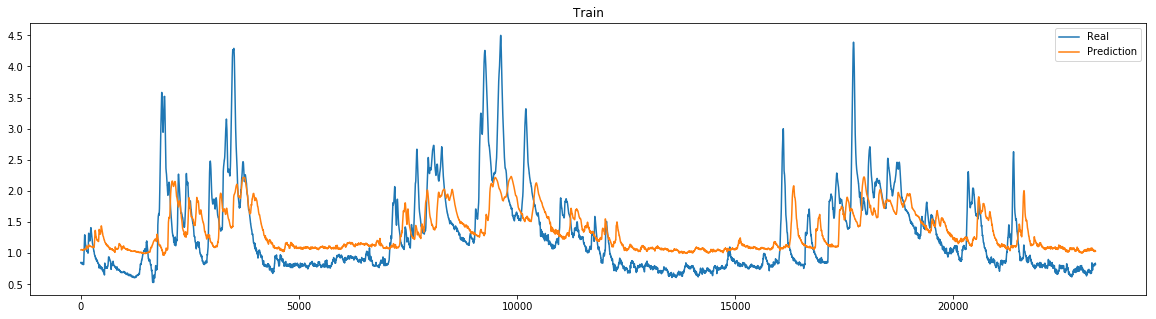

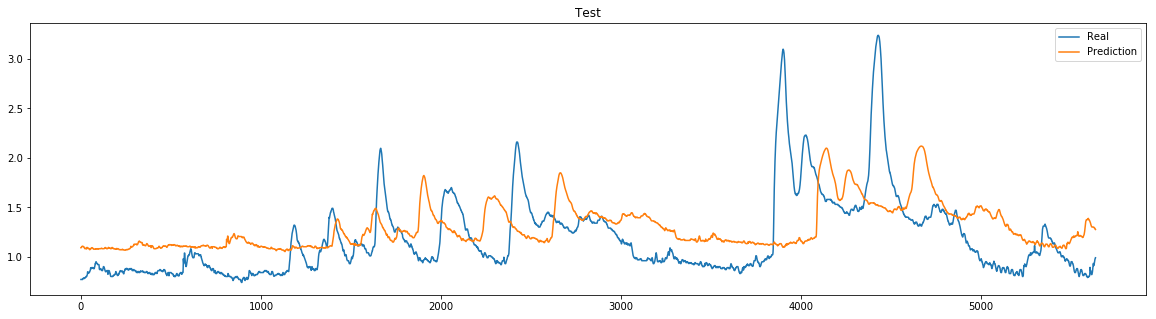

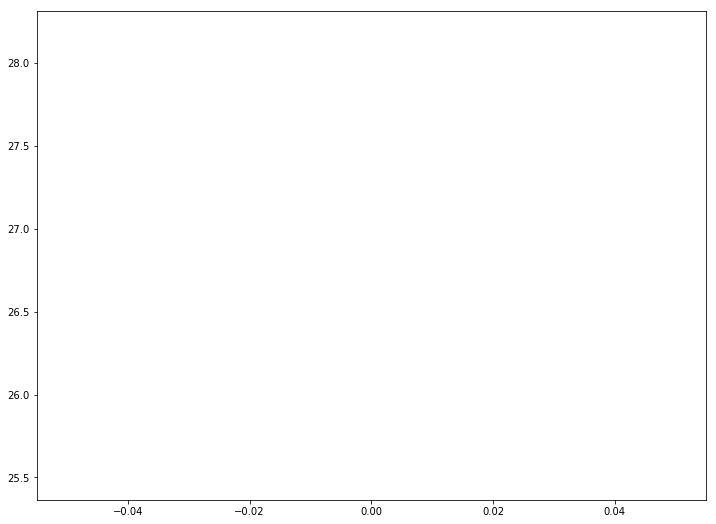

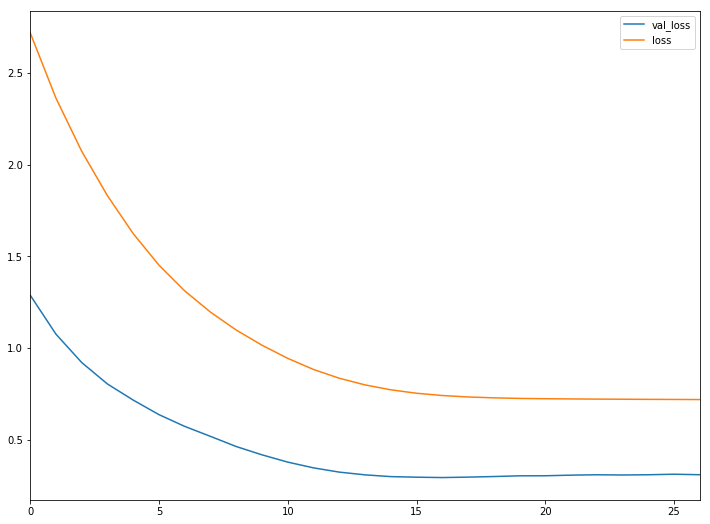

In [41]:
    plt.figure(figsize=(20,5))
    pred_i = 0
    plt.plot(train_ytrue[:, pred_i, 0], label="Real")
    plt.plot(train_yhat[:, pred_i, 0], label="Prediction")
    plt.title("Train")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(test_ytrue[:, pred_i, 0], label="Real")
    plt.plot(test_yhat[:, pred_i, 0], label="Prediction")
    plt.title("Test")
    plt.legend()
    plt.show()

    plt.plot(errors)
    plt.show()

    pd.DataFrame(history.history).plot()
    plt.show()

In [44]:
errors

[26.841519989560492]

In [7]:
train_ytrue[0][:5]

array([[0.81  ],
       [0.8175],
       [0.82  ],
       [0.82  ],
       [0.83  ]])

In [10]:
train_yhat[0][:5]

array([[1.0127703],
       [1.0127703],
       [1.0127703],
       [1.0127703],
       [1.0127703]], dtype=float32)

In [12]:
train_y.shape

(23395, 73, 1)

In [13]:
train_x.shape

(23395, 168, 1)

In [14]:
river.shape

(29544, 1)

In [30]:
train_x[:3, :7]

array([[[-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71549222]],

       [[-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71549222],
        [-0.70514896]],

       [[-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71893997],
        [-0.71549222],
        [-0.70514896],
        [-0.70514896]]])

In [29]:
river[:7]

array([[-0.71893997],
       [-0.71893997],
       [-0.71893997],
       [-0.71893997],
       [-0.71893997],
       [-0.71893997],
       [-0.71549222]])

In [32]:
train_y[:3, :7]/river_std - river_mean

array([[[0.43365813],
        [0.41939374],
        [0.40988415],
        [0.38611018],
        [0.36709099],
        [0.33856222],
        [0.30527865]],

       [[0.41939374],
        [0.40988415],
        [0.38611018],
        [0.36709099],
        [0.33856222],
        [0.30527865],
        [0.28625947]],

       [[0.40988415],
        [0.38611018],
        [0.36709099],
        [0.33856222],
        [0.30527865],
        [0.28625947],
        [0.25297591]]])

In [45]:
river[look_back]/river_std - river_mean

array([0.43365813])

In [17]:
river.shape[0] * 0.8 - look_back - look_ahead

72579.8

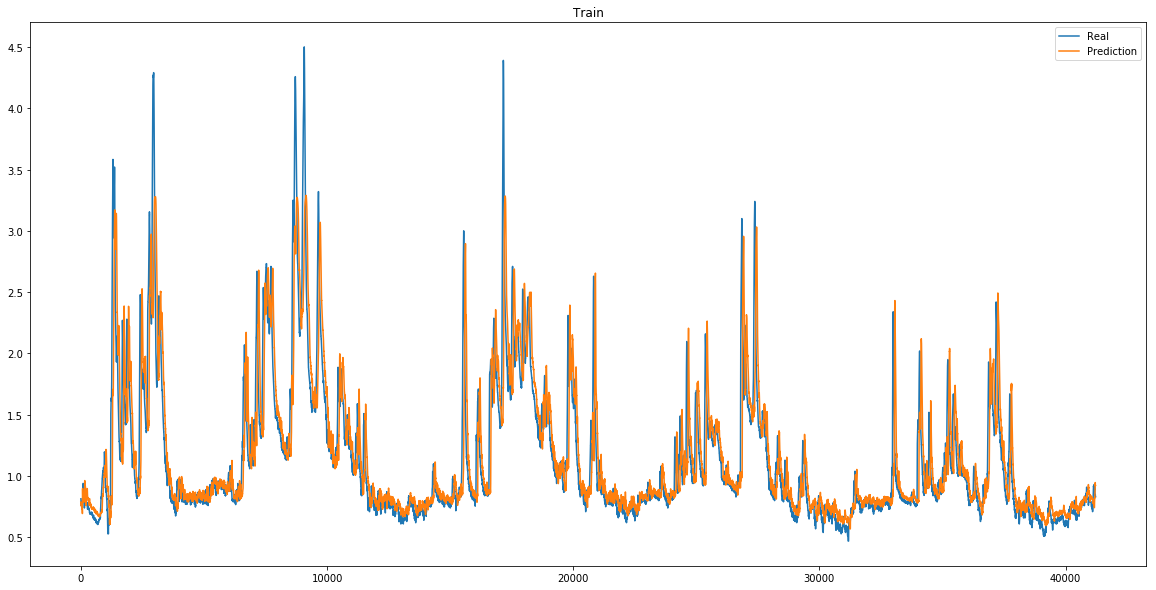

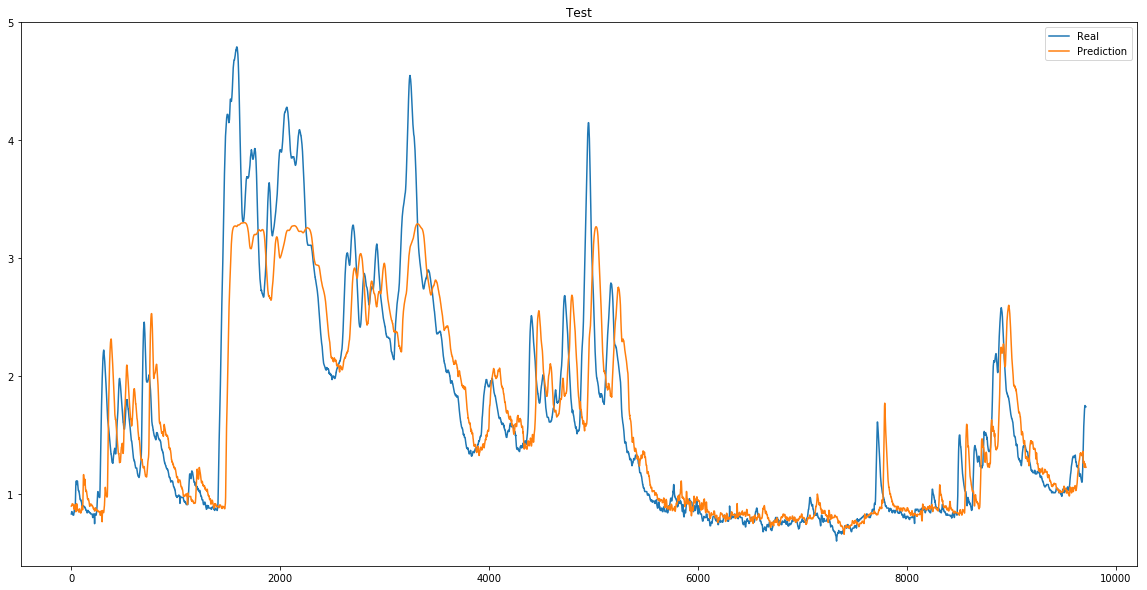

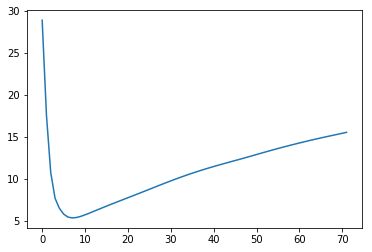

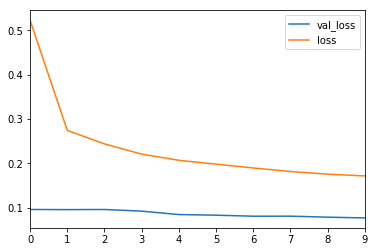

In [19]:
    plt.figure(figsize=(20,10))
    plt.plot(train_ytrue[:, 71, 0], label="Real")
    plt.plot(train_yhat[:, 71, 0], label="Prediction")
    plt.title("Train")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,10))
    plt.plot(test_ytrue[:, 71, 0], label="Real")
    plt.plot(test_yhat[:, 71, 0], label="Prediction")
    plt.title("Test")
    plt.legend()
    plt.show()

    plt.plot(errors)
    plt.show()

    pd.DataFrame(history.history).plot()
    plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()

# CNN

In [6]:
# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
river = all_levels[:, 5]
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

In [7]:
all_levels[:, 5]

array([0.74, 0.74, 0.74, ..., 1.05, 1.05, 1.05])

In [8]:
scores = []
history = []
model_list = []
river_i_list = [5]
# look_back = 24*30 * 24
look_ahead = 72
N = 24*7*21 * look_ahead
split = 0.8
batch_size=1200

river = all_levels[:N, 5]  # zgz

# normalize
river_mean, river_std = river.mean(), river.std()
river = preprocessing.scale(river)[:, None]

In [9]:
# split data into train and test subsets
train, test = train_test_split(river, split)

In [114]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps, jump=0):
    X, y = list(), list()
    last_idx = len(sequence)-jump-1
    for i in range(last_idx):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > last_idx:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix+jump]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [142]:
1000/24

41.666666666666664

In [115]:
train.shape

(76684, 1)

In [116]:
# choose a number of time steps
n_steps = 1000
# split into samples
X, y = split_sequence(train, n_steps, jump=72)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = scaler.fit_transform(X)

In [117]:
X.shape

(75612, 1000, 1)

In [118]:
y.shape

(75612, 1)

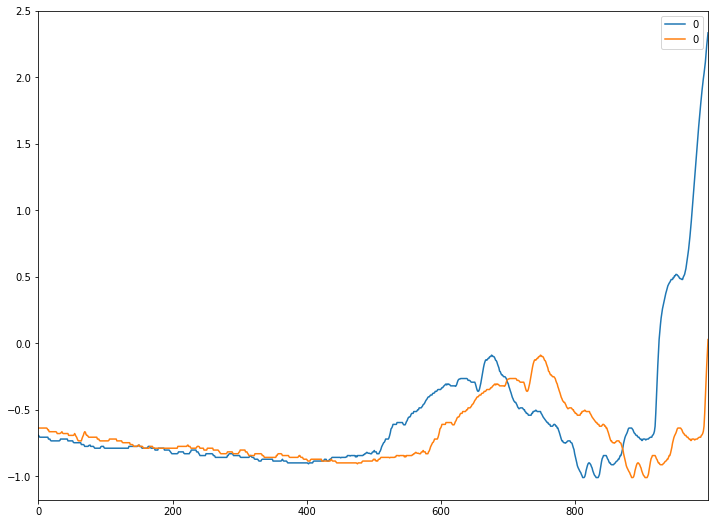

In [122]:
ax = pd.DataFrame(y[:1000]).plot(label="y")
pd.DataFrame(X[:1000,-1,0]).plot(ax=ax)

In [136]:
# MODEL
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=200, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=20, kernel_size=200, activation='relu'))
model.add(Conv1D(filters=20, kernel_size=100, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 801, 64)           12864     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 400, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 201, 20)           256020    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 102, 20)           40020     
_________________________________________________________________
flatten_6 (Flatten)          (None, 2040)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                20410     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total para

In [138]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.preprocessing import StandardScaler

Train on 60489 samples, validate on 15123 samples
Epoch 1/15
 - 1705s - loss: 0.7796 - val_loss: 0.8666
Epoch 2/15
 - 1740s - loss: 0.5608 - val_loss: 0.7623
Epoch 3/15
 - 1930s - loss: 0.4843 - val_loss: 0.8086
Epoch 4/15
 - 1893s - loss: 0.4128 - val_loss: 0.7583
Epoch 5/15
 - 1780s - loss: 0.3367 - val_loss: 0.5819
Epoch 6/15
 - 1957s - loss: 0.2962 - val_loss: 0.5530
Epoch 7/15
 - 1849s - loss: 0.2705 - val_loss: 0.5088
Epoch 8/15
 - 1859s - loss: 0.2485 - val_loss: 0.4736
Epoch 9/15
 - 1854s - loss: 0.2242 - val_loss: 0.5234
Epoch 10/15
 - 1786s - loss: 0.2074 - val_loss: 0.4653
Epoch 11/15
 - 1710s - loss: 0.1842 - val_loss: 0.4321
Epoch 12/15
 - 1684s - loss: 0.1695 - val_loss: 0.4639
Epoch 13/15
 - 1690s - loss: 0.1485 - val_loss: 0.5504
Epoch 14/15
 - 1730s - loss: 0.1474 - val_loss: 0.5282
Epoch 00014: early stopping


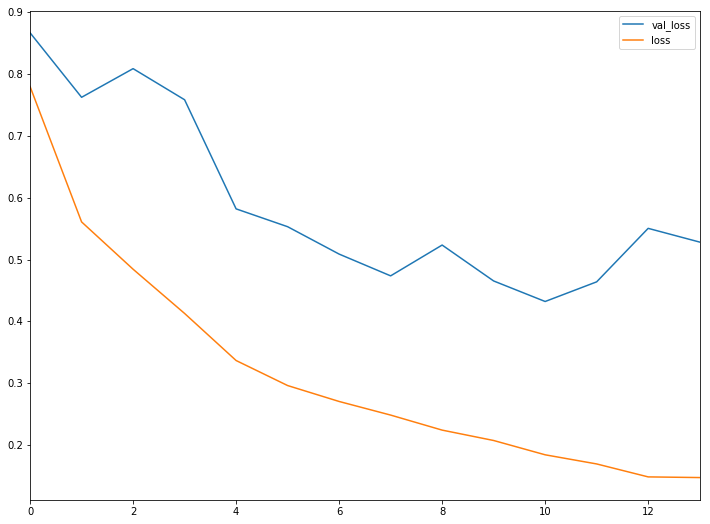

In [140]:
pd.DataFrame(history.history).plot()

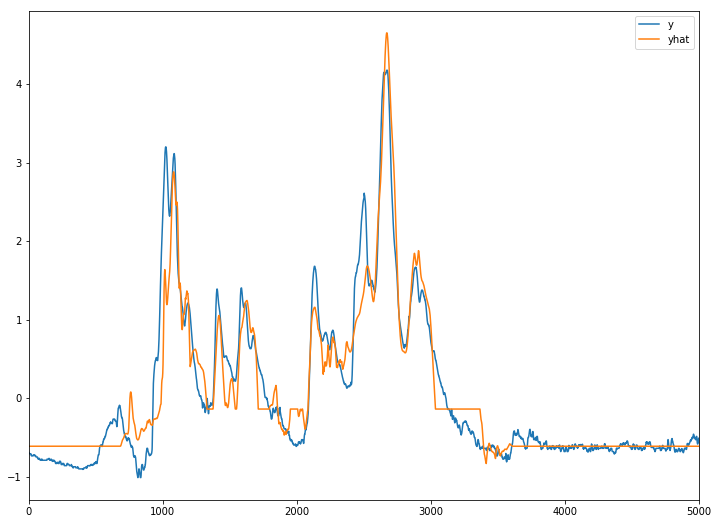

In [141]:
yhat=model.predict(X)



ax = pd.DataFrame(y[:5000], columns=["y"]).plot()
pd.DataFrame(yhat[:5000], columns=["yhat"]).plot(ax=ax)

In [157]:
np.mean(X.flat)

0.03261622810330724

In [158]:
scaler.fit_transform(X.flatten()[:, None])

1.1821554685796353e-16

In [166]:
test_ = scaler.transform(test)

In [168]:
test_

array([[-0.74889128],
       [-0.74889128],
       [-0.74889128],
       ...,
       [-0.31706789],
       [-0.31706789],
       [-0.31706789]])

In [169]:
# choose a number of time steps
n_steps = 1000
# split into samples
X, y = split_sequence(test_, n_steps, jump=72)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

In [172]:
X.shape

(18100, 1000, 1)

In [ ]:
model.predict(X)

In [ ]:
errors = [mean_absolute_percentage(test_ytrue[:,i,:], test_yhat[:,i,:]) for i in range(test_ytrue.shape[1])]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_ytrue[:, 71, 0], label="Real")
plt.plot(train_yhat[:, 71, 0], label="Prediction")
plt.title("Train")
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(test_ytrue[:, 71, 0], label="Real")
plt.plot(test_yhat[:, 71, 0], label="Prediction")
plt.title("Test")
plt.legend()
plt.show()

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
pd.DataFrame(history.history).plot()
plt.show()

In [1]:
model

NameError: name 'model' is not defined